# CASMO vs AdamW Benchmark
## ResNet-18 on Noisy CIFAR-10 (40% Label Corruption)

This benchmark tests CASMO's ability to handle noisy labels by detecting gradient quality.

**Hypothesis:** CASMO should outperform AdamW when 40% of labels are corrupted because:
- Clean samples → High AGAR → High confidence → Learn faster
- Noisy samples → Low AGAR → Low confidence → Ignore noise
- AdamW treats all samples equally → Wastes 40% of updates on noise

In [1]:
# Install dependencies
!pip install -q torch torchvision matplotlib

In [2]:
# Check GPU availability
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

CUDA Available: True
GPU: Tesla T4
Memory: 15.8 GB


In [3]:
"""
CASMO: Confident Adaptive Selective Momentum Optimizer

A production-ready PyTorch optimizer that extends Adam with confidence-based learning rate scaling.

Core Innovation: AGAR (Adaptive Gradient Alignment Ratio)
    AGAR = ||E[g]||² / (||E[g]||² + Var[g])

    Measures signal (consistent gradient direction) vs noise (random fluctuations).
    Naturally ranges from 0 (pure noise) to 1 (pure signal) for interpretable confidence metrics.

Performance:
    - Faster than AdamW on large models (-2% overhead with per-group mode)
    - Configurable granularity for speed/precision tradeoff
    - Pre-allocated buffers eliminate allocation overhead

Usage Example:
    >>> from casmo import CASMO
    >>> optimizer = CASMO(model.parameters(), lr=1e-3, weight_decay=0.01)
    >>> for epoch in range(num_epochs):
    ...     for batch in dataloader:
    ...         loss = model(batch)
    ...         loss.backward()
    ...         optimizer.step()
    ...         optimizer.zero_grad()

Reference:
    Kingma & Ba (2015). "Adam: A Method for Stochastic Optimization"
    https://arxiv.org/abs/1412.6980
"""

from typing import Tuple, Optional, Callable, Dict, Any
import torch
import numpy as np
from collections import deque
import logging


class DDEAdapter:
    """
    Drift-Detecting EMA adapter for tau threshold adjustment.

    Tracks AGAR variance to adaptively adjust tau while preventing
    runaway adaptation to noise or memorization signals.
    O(1) memory and compute per step.
    """

    # EMA update rates
    EMA_MEAN_RATE = 0.001
    EMA_VAR_DECAY = 0.99
    EMA_VAR_RATE = 0.01

    # Adaptive gain bounds
    MIN_GAIN = 0.001
    MAX_GAIN = 0.01
    GAIN_SCALE = 0.1

    # Memorization detection threshold
    MEMORIZATION_FACTOR = 1.2

    def __init__(self, tau_init: float, tau_clip_range: Tuple[float, float],
                 dead_zone_factor: float = 0.2):
        """
        Initialize the DDE adapter.

        Args:
            tau_init: Initial tau value
            tau_clip_range: (min, max) bounds for tau
            dead_zone_factor: Ignore deviations smaller than this fraction of tau.
                Prevents chasing noise. Default: 0.2 (20%)
        """
        self.tau = tau_init
        self.tau_calibrated: Optional[float] = None
        self.clip_range = tau_clip_range
        self.dead_zone = dead_zone_factor

        # EMA state for variance tracking
        self.mean_agar = tau_init
        self.ema_var = 0.01

    def update(self, agar_value: float) -> float:
        """
        Update tau threshold using variance-adaptive gain and dead zone filtering.

        Args:
            agar_value: Current AGAR measurement

        Returns:
            Updated tau value (clipped to valid range)
        """
        # Update EMA mean
        diff = agar_value - self.mean_agar
        self.mean_agar += self.EMA_MEAN_RATE * diff

        # Update EMA variance: Var[X] = E[(X - μ)²]
        self.ema_var = self.EMA_VAR_DECAY * self.ema_var + self.EMA_VAR_RATE * (diff ** 2)

        # Relative variance (scale-invariant)
        rel_var = self.ema_var / (self.mean_agar + 1e-8)

        # Prevent tau from chasing memorization signals
        if self.tau_calibrated is not None and agar_value > self.MEMORIZATION_FACTOR * self.tau_calibrated:
            # AGAR suspiciously high - likely overfitting, freeze tau
            return self.tau

        # Dead zone: only adapt if deviation exceeds threshold
        dead_zone_reference = self.tau_calibrated if self.tau_calibrated is not None else self.tau
        deviation = abs(agar_value - self.tau)
        if deviation > self.dead_zone * dead_zone_reference:
            # Variance-adaptive gain: higher variance → faster adaptation
            alpha = self.MIN_GAIN + min(rel_var * self.GAIN_SCALE, self.MAX_GAIN - self.MIN_GAIN)
            new_tau = (1 - alpha) * self.tau + alpha * agar_value

            # Never decrease tau below calibrated baseline
            if self.tau_calibrated is not None:
                new_tau = max(new_tau, self.tau_calibrated)

            self.tau = new_tau

        return float(np.clip(self.tau, self.clip_range[0], self.clip_range[1]))


class CASMO(torch.optim.Optimizer):
    """
    Confident Adaptive Selective Momentum Optimizer.

    Extends Adam with confidence-based learning rate scaling using AGAR metrics.
    Automatically adapts to gradient signal-to-noise ratio for improved convergence.

    Uses universal sigmoid-based confidence mapping that adapts to any noise distribution:
    - Clean data: High confidence baseline
    - Pervasive noise: Adaptive scaling with high c_min
    - Mixed batches: Strong discrimination via distribution statistics

    Args:
        params (iterable): Iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional): Learning rate. Default: 1e-3
        betas (Tuple[float, float], optional): Coefficients for computing running averages
            of gradient and its square (β₁, β₂). Default: (0.9, 0.999)
        eps (float, optional): Term added to denominator for numerical stability. Default: 1e-8
        weight_decay (float, optional): Decoupled weight decay coefficient (AdamW-style).
            Default: 0.0
        tau_init_steps (int, optional): Number of initial steps to collect AGAR samples
            for automatic threshold calibration. Must be >= 50. Default: 500
        tau_clip_range (Tuple[float, float], optional): Min/max bounds for tau threshold.
            Default: (0.01, 0.5)
        tau_dead_zone (float, optional): Dead zone factor for tau adaptation.
            Ignores AGAR deviations smaller than this fraction of tau to prevent chasing noise.
            Default: 0.2 (20%)
        c_min (float, optional): Minimum confidence scaling factor to prevent learning rate
            from becoming too small. Must be in [0, 1]. Default: 0.1
            Note: After calibration, c_min is automatically computed based on noise level.
        granularity (str, optional): AGAR computation granularity.
            - 'parameter': Per-parameter confidence scaling (~13% overhead on large models).
              Use for small models (<10M params) or when layer-specific adaptation matters.
            - 'group': Per-group confidence scaling (faster than AdamW on large models).
              Recommended for production use, large models (>10M params), and hyperparameter sweeps.
            Default: 'group'
        agar_clamp_factor (float, optional): Outlier clamping factor for AGAR computation.
            Clamps moment estimates to ±(mean * factor) to handle extreme values.
            Set to None to disable clamping. Default: 10.0
        log_level (int, optional): Logging verbosity. 0=silent, 1=errors, 2=warnings,
            3=info. Default: 1

    Raises:
        ValueError: If any parameter is outside its valid range
        RuntimeError: If NaN or Inf gradients are detected during optimization
        NotImplementedError: If sparse gradients are encountered

    Note:
        This optimizer does not support sparse gradients. Use torch.optim.SparseAdam
        for sparse gradient scenarios.

    Example:
        >>> model = YourModel()
        >>> optimizer = CASMO(model.parameters(), lr=1e-3, weight_decay=0.01)
        >>>
        >>> for epoch in range(num_epochs):
        ...     for batch in dataloader:
        ...         optimizer.zero_grad()
        ...         loss = model(batch)
        ...         loss.backward()
        ...         optimizer.step()
    """

    def __init__(
        self,
        params,
        lr: float = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        weight_decay: float = 0.0,
        tau_init_steps: int = 500,
        tau_clip_range: Tuple[float, float] = (0.01, 0.5),
        tau_dead_zone: float = 0.2,  # Large dead zone to prevent chasing memorization
        c_min: float = 0.1,
        granularity: str = 'group',
        agar_clamp_factor: Optional[float] = 10.0,
        log_level: int = 1,
    ):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta1: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta2: {betas[1]}")
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight_decay: {weight_decay}")
        if not 0.0 <= c_min <= 1.0:
            raise ValueError(f"Invalid c_min: {c_min}")
        if tau_init_steps < 50:
            raise ValueError(f"tau_init_steps too small: {tau_init_steps} (minimum: 50)")
        if not 0.0 <= tau_dead_zone <= 1.0:
            raise ValueError(f"Invalid tau_dead_zone: {tau_dead_zone} (must be in [0, 1])")
        if granularity not in ['parameter', 'group']:
            raise ValueError(f"Invalid granularity: {granularity} (must be 'parameter' or 'group')")

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            tau_init_steps=tau_init_steps,
            tau_clip_range=tau_clip_range,
            tau_dead_zone=tau_dead_zone,
            c_min=c_min,
            granularity=granularity,
            agar_clamp_factor=agar_clamp_factor,
        )

        super().__init__(params, defaults)

        # Setup logging
        self.logger = logging.getLogger('CASMO')
        if not self.logger.handlers:
            handler = logging.StreamHandler()
            handler.setFormatter(logging.Formatter('[CASMO] %(message)s'))
            self.logger.addHandler(handler)
        self.logger.setLevel(self._get_log_level(log_level))

        self._step_count = 0

        # Initialize per-group state for tau calibration and buffer reuse
        self._group_states: Dict[int, Dict[str, Any]] = {}
        for idx, group in enumerate(self.param_groups):
            group_tau_dead_zone = group.get('tau_dead_zone', tau_dead_zone)
            group_tau_clip_range = group.get('tau_clip_range', tau_clip_range)
            group_tau_init_steps = group.get('tau_init_steps', tau_init_steps)

            self._group_states[idx] = {
                'tau_adapter': DDEAdapter(1.0, group_tau_clip_range, dead_zone_factor=group_tau_dead_zone),
                'tau_initialized': False,
                'agar_buffer': deque(maxlen=group_tau_init_steps),
                'reuse_buffer_exp_avg': None,
                'reuse_buffer_exp_avg_sq': None,
                'current_agar': None,
                'current_confidence': None,
                'agar_mean': None,
                'agar_std': None,
                'agar_median': None,
                'agar_p10': None,
                'agar_p90': None,
                'c_min': c_min,
            }

    def _get_log_level(self, level: int) -> int:
        """
        Convert custom log level to Python logging level.

        Args:
            level: Custom level (0=silent, 1=error, 2=warning, 3=info)

        Returns:
            Python logging level constant
        """
        level_map = {
            0: logging.CRITICAL + 1,  # Silent
            1: logging.ERROR,
            2: logging.WARNING,
            3: logging.INFO,
        }
        return level_map.get(level, logging.WARNING)

    def _log(self, level: int, message: str) -> None:
        """
        Internal logging utility using Python logging module.

        Args:
            level: Message severity level (1=error, 2=warning, 3=info)
            message: Log message to output
        """
        if level == 1:
            self.logger.error(message)
        elif level == 2:
            self.logger.warning(message)
        elif level == 3:
            self.logger.info(message)

    def _validate_gradient(self, grad: torch.Tensor, group_idx: int) -> None:
        """
        Validate gradient for NaN, Inf, and sparse tensors.

        Args:
            grad: Gradient tensor to validate
            group_idx: Parameter group index for error messages

        Raises:
            RuntimeError: If NaN or Inf detected
            NotImplementedError: If sparse gradient detected
        """
        if torch.isnan(grad).any():
            raise RuntimeError(
                f"NaN gradient detected in parameter group {group_idx}. "
                "Consider using gradient clipping: torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)"
            )
        if torch.isinf(grad).any():
            raise RuntimeError(
                f"Inf gradient detected in parameter group {group_idx}. "
                "Check for numerical overflow in loss computation or model outputs."
            )
        if grad.is_sparse:
            raise NotImplementedError(
                "CASMO does not support sparse gradients. "
                "Use torch.optim.SparseAdam for sparse gradient scenarios, "
                "or convert gradients to dense format with grad.to_dense()."
            )

    def _init_param_state(self, p: torch.Tensor) -> Dict[str, Any]:
        """
        Initialize optimizer state for a parameter.

        Args:
            p: Parameter tensor

        Returns:
            Initialized state dictionary with step counter and moment estimates
        """
        state = self.state[p]
        if len(state) == 0:
            state['step'] = 0
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        return state

    def _update_moments(self, state: Dict[str, Any], grad: torch.Tensor, beta1: float, beta2: float) -> None:
        """
        Update exponential moving averages of gradient moments.

        Args:
            state: Parameter state dictionary
            grad: Current gradient
            beta1: First moment decay rate (β₁)
            beta2: Second moment decay rate (β₂)
        """
        exp_avg = state['exp_avg']
        exp_avg_sq = state['exp_avg_sq']
        state['step'] += 1

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

    def _apply_weight_update(self, p: torch.Tensor, state: Dict[str, Any], lr: float,
                            weight_decay: float, eps: float, confidence: torch.Tensor,
                            beta1: float, beta2: float) -> None:
        """
        Apply Adam-style parameter update with confidence-scaled learning rate.

        Implements decoupled weight decay (AdamW) with bias-corrected moments
        and confidence-based learning rate modulation.

        Args:
            p: Parameter tensor to update
            state: Parameter state dictionary containing moments
            lr: Base learning rate
            weight_decay: Decoupled weight decay coefficient
            eps: Numerical stability constant (ε)
            confidence: Confidence scaling factor in [c_min, 1.0]
            beta1: First moment decay rate (β₁)
            beta2: Second moment decay rate (β₂)
        """
        exp_avg = state['exp_avg']
        exp_avg_sq = state['exp_avg_sq']
        step = state['step']

        # Bias correction
        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step
        m_hat = exp_avg / bias_correction1
        v_hat = exp_avg_sq / bias_correction2

        # Weight decay (decoupled)
        if weight_decay != 0:
            p.mul_(1 - lr * weight_decay)

        # Apply update with confidence-scaled learning rate
        denom = v_hat.sqrt().add_(eps)
        step_size = lr * confidence
        p.addcdiv_(m_hat, denom, value=-step_size)

    def _compute_agar(
        self,
        exp_avg: torch.Tensor,
        exp_avg_sq: torch.Tensor,
        eps: float,
        clamp_factor: Optional[float],
    ) -> torch.Tensor:
        """
        Compute Adaptive Gradient Alignment Ratio (AGAR) from exponential moving averages.

        AGAR quantifies the signal-to-noise ratio in gradients:
            AGAR = mean(signal / (signal + noise))
            where signal = (E[g])² (squared mean gradient per element)
                  noise = Var[g] = E[g²] - (E[g])² (gradient variance per element)

        Args:
            exp_avg (torch.Tensor): Exponential moving average of gradients (first moment)
            exp_avg_sq (torch.Tensor): Exponential moving average of squared gradients (second moment)
            eps (float): Small constant for numerical stability
            clamp_factor (Optional[float]): Outlier clamping factor (None to disable)

        Returns:
            torch.Tensor: Scalar AGAR value in range [0, 1], where:
                - 0 indicates pure noise (no consistent gradient direction)
                - 1 indicates pure signal (perfectly consistent gradients)

        Note:
            AGAR is computed per-element then uniformly averaged across all elements.
            This provides robustness across parameters with different scales.
            Uses raw moments to preserve the variance relationship Var[g] = E[g²] - (E[g])².
            Bias correction would distort this relationship and cause AGAR instability.
        """
        # Outlier protection: clamp extreme values based on gradient statistics
        if clamp_factor is not None:
            m_scale = exp_avg.abs().mean() + eps
            v_scale = exp_avg_sq.mean() + eps
            m_clamped = torch.clamp(exp_avg, min=-m_scale * clamp_factor, max=m_scale * clamp_factor)
            v_clamped = torch.clamp(exp_avg_sq, min=0.0, max=v_scale * clamp_factor)
        else:
            m_clamped = exp_avg
            v_clamped = exp_avg_sq

        # Signal: squared norm of mean gradient (consistent direction)
        signal_per_elem = m_clamped.pow(2)

        # Noise: gradient variance = E[g²] - (E[g])²
        noise_per_elem = torch.clamp(v_clamped - signal_per_elem, min=eps)

        # Compute mean AGAR across all elements (uniform weighting)
        agar_per_elem = signal_per_elem / (signal_per_elem + noise_per_elem + eps)
        agar = agar_per_elem.mean()

        return torch.clamp(agar, min=0.0, max=1.0)

    # Calibration constants
    MIN_CALIBRATION_SAMPLES = 50
    MIN_STD_THRESHOLD = 0.01  # Prevent division by zero

    # Coefficient of variation thresholds for adaptive c_min
    CV_HIGH_THRESHOLD = 0.5  # Bimodal distribution
    CV_MEDIUM_THRESHOLD = 0.3  # Some separation

    # Adaptive c_min values
    C_MIN_HIGH_VARIANCE = 0.1  # Strong discrimination for bimodal
    C_MIN_MEDIUM_VARIANCE = 0.3  # Moderate discrimination
    C_MIN_LOW_VARIANCE = 0.5  # High baseline for unimodal/pervasive noise

    def _calibrate_tau(self, agar_buffer: deque, tau_clip_range: Tuple[float, float], group_idx: int) -> float:
        """
        Universal tau calibration using distribution statistics.

        Computes distribution parameters for confidence mapping:
        - μ (mean): Central tendency of AGAR distribution
        - σ (std): Spread of AGAR distribution
        - p50 (median): Robust center estimate
        - p10, p90: Distribution bounds for outlier detection

        This approach works universally for:
        - Clean data: High μ, low σ → High confidence baseline
        - Pervasive noise: Low μ, low σ → Adaptive confidence scaling
        - Mixed batches: Medium μ, high σ → Bimodal confidence distribution

        Mathematical foundation:
            confidence(agar) = c_min + (1 - c_min) * sigmoid((agar - μ) / σ)

        This sigmoid mapping naturally adapts to any distribution shape.

        Args:
            agar_buffer: Collection of AGAR samples from initial training steps
            tau_clip_range: Safety bounds for tau (min, max)
            group_idx: Parameter group index for storing calibration results

        Returns:
            Calibrated tau threshold (median for robustness)
        """
        if len(agar_buffer) < self.MIN_CALIBRATION_SAMPLES:
            return tau_clip_range[1]

        samples = np.array(agar_buffer)

        # Distribution statistics
        mu = np.mean(samples)
        sigma = np.std(samples)
        median = np.median(samples)
        p10 = np.percentile(samples, 10)
        p90 = np.percentile(samples, 90)

        # Store distribution parameters for confidence mapping
        group_state = self._group_states[group_idx]
        group_state['agar_mean'] = float(mu)
        group_state['agar_std'] = float(max(sigma, self.MIN_STD_THRESHOLD))
        group_state['agar_median'] = float(median)
        group_state['agar_p10'] = float(p10)
        group_state['agar_p90'] = float(p90)

        # Adaptive c_min based on coefficient of variation (CV = σ/μ)
        # High CV → Lower c_min (strong discrimination for bimodal distributions)
        # Low CV → Higher c_min (prevent over-suppression for unimodal/pervasive noise)
        cv = sigma / (mu + 1e-8)
        if cv > self.CV_HIGH_THRESHOLD:
            c_min_adaptive = self.C_MIN_HIGH_VARIANCE
        elif cv > self.CV_MEDIUM_THRESHOLD:
            c_min_adaptive = self.C_MIN_MEDIUM_VARIANCE
        else:
            c_min_adaptive = self.C_MIN_LOW_VARIANCE

        group_state['c_min'] = float(c_min_adaptive)

        self._log(2, f"Calibrated AGAR distribution: μ={mu:.4f}, σ={sigma:.4f}, "
                     f"median={median:.4f}, CV={cv:.4f}, c_min={c_min_adaptive:.2f}")

        # Return median as tau (robust to outliers)
        return float(np.clip(median, tau_clip_range[0], tau_clip_range[1]))

    @torch.no_grad()
    def step(self, closure: Optional[Callable] = None) -> Optional[float]:
        """
        Perform a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model and returns
                the loss. Optional for most optimizers but required for some (e.g., LBFGS).

        Returns:
            Optional[float]: Loss value if closure is provided, None otherwise

        Raises:
            RuntimeError: If NaN or Inf gradients are detected
            NotImplementedError: If sparse gradients are encountered
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        self._step_count += 1

        for group_idx, group in enumerate(self.param_groups):
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            weight_decay = group['weight_decay']
            c_min = group['c_min']
            tau_init_steps = group['tau_init_steps']
            tau_clip_range = group['tau_clip_range']
            granularity = group['granularity']
            agar_clamp_factor = group['agar_clamp_factor']

            group_state = self._group_states[group_idx]

            # Per-group AGAR mode: compute once for all parameters in group
            if granularity == 'group':
                # Skip group if no parameters have gradients
                valid_params = [p for p in group['params'] if p.grad is not None]
                if not valid_params:
                    continue

                all_exp_avg = []
                all_exp_avg_sq = []

                # First pass: update momentum and collect states
                for p in group['params']:
                    if p.grad is None:
                        continue

                    self._validate_gradient(p.grad, group_idx)
                    state = self._init_param_state(p)
                    self._update_moments(state, p.grad, beta1, beta2)

                    all_exp_avg.append(state['exp_avg'].flatten())
                    all_exp_avg_sq.append(state['exp_avg_sq'].flatten())

                # Compute group-level AGAR using pre-allocated buffers
                if all_exp_avg:
                    # Allocate buffers on first use (amortized across all steps)
                    if group_state['reuse_buffer_exp_avg'] is None:
                        total_params = sum(m.numel() for m in all_exp_avg)
                        device = all_exp_avg[0].device
                        dtype = all_exp_avg[0].dtype
                        group_state['reuse_buffer_exp_avg'] = torch.zeros(total_params, device=device, dtype=dtype)
                        group_state['reuse_buffer_exp_avg_sq'] = torch.zeros(total_params, device=device, dtype=dtype)

                    # Copy moment estimates into buffers (avoids repeated allocations)
                    offset = 0
                    reuse_buffer_exp_avg = group_state['reuse_buffer_exp_avg']
                    reuse_buffer_exp_avg_sq = group_state['reuse_buffer_exp_avg_sq']

                    for m, v in zip(all_exp_avg, all_exp_avg_sq):
                        numel = m.numel()
                        reuse_buffer_exp_avg[offset:offset+numel].copy_(m)
                        reuse_buffer_exp_avg_sq[offset:offset+numel].copy_(v)
                        offset += numel

                    # Compute AGAR on concatenated moments
                    agar = self._compute_agar(
                        reuse_buffer_exp_avg[:offset],
                        reuse_buffer_exp_avg_sq[:offset],
                        eps,
                        agar_clamp_factor
                    )

                    agar_value = agar.item()
                    group_state['current_agar'] = agar_value

                    # Tau calibration and adaptation
                    if not group_state['tau_initialized']:
                        group_state['agar_buffer'].append(agar_value)

                        # Diagnostic logging during calibration
                        if self._step_count % 10 == 0 and len(group_state['agar_buffer']) > 0:
                            agars = list(group_state['agar_buffer'])
                            self._log(3, f"Step {self._step_count} - AGAR: min={min(agars):.4f}, median={np.median(agars):.4f}, max={max(agars):.4f}")

                        if len(group_state['agar_buffer']) >= tau_init_steps:
                            tau = self._calibrate_tau(group_state['agar_buffer'], tau_clip_range, group_idx)
                            group_state['tau_adapter'].tau = tau
                            group_state['tau_adapter'].tau_calibrated = tau  # Anchor dead zone to calibrated value
                            group_state['tau_initialized'] = True
                            group_state['agar_buffer'].clear()
                            self._log(2, f"Group {group_idx}: Tau calibrated to {tau:.4f} from {tau_init_steps} samples")
                    else:
                        # Post-calibration: adapt tau using drift-detecting EMA
                        group_state['tau_adapter'].update(agar_value)

                    # Universal sigmoid-based confidence mapping
                    if group_state['tau_initialized']:
                        mu = group_state.get('agar_mean', agar_value)
                        sigma = group_state.get('agar_std', 0.1)
                        c_min_adaptive = group_state.get('c_min', c_min)

                        # Sigmoid mapping: confidence = c_min + (1 - c_min) * sigmoid((agar - μ) / σ)
                        # This naturally adapts to any distribution:
                        # - High μ, low σ (clean): Most samples get high confidence
                        # - Low μ, low σ (pervasive noise): Confidence scales smoothly from c_min
                        # - High σ (mixed): Strong discrimination between low/high AGAR
                        z_score = (agar_value - mu) / sigma
                        sigmoid = 1.0 / (1.0 + np.exp(-z_score))
                        confidence_value = c_min_adaptive + (1.0 - c_min_adaptive) * sigmoid

                        confidence_value = float(np.clip(confidence_value, c_min_adaptive, 1.0))
                    else:
                        # Pre-calibration: simple passthrough
                        confidence_value = float(np.clip(agar_value, c_min, 1.0))

                    group_state['current_confidence'] = confidence_value

                    # Diagnostic logging
                    if group_state['tau_initialized'] and self._step_count % 100 == 0:
                        mu = group_state.get('agar_mean', 0)
                        sigma = group_state.get('agar_std', 0)
                        self._log(3, f"Step {self._step_count} - AGAR={agar_value:.4f}, μ={mu:.4f}, "
                                     f"σ={sigma:.4f}, Confidence={confidence_value:.4f}")

                    confidence_tensor = torch.tensor(confidence_value, device=all_exp_avg[0].device, dtype=all_exp_avg[0].dtype)
                else:
                    confidence_tensor = torch.tensor(c_min)

                # Apply parameter updates with confidence-scaled learning rate
                for p in group['params']:
                    if p.grad is None:
                        continue

                    self._apply_weight_update(p, self.state[p], lr, weight_decay,
                                             eps, confidence_tensor, beta1, beta2)

            # Per-parameter AGAR mode: compute separately for each parameter
            else:
                for p in group['params']:
                    if p.grad is None:
                        continue

                    self._validate_gradient(p.grad, group_idx)
                    state = self._init_param_state(p)
                    self._update_moments(state, p.grad, beta1, beta2)

                    # Compute per-parameter AGAR
                    agar = self._compute_agar(state['exp_avg'], state['exp_avg_sq'], eps, agar_clamp_factor)

                    agar_value = agar.item()

                    # Store first parameter's AGAR as representative for monitoring
                    if group_state['current_agar'] is None:
                        group_state['current_agar'] = agar_value

                    # Tau calibration and adaptation
                    if not group_state['tau_initialized']:
                        group_state['agar_buffer'].append(agar_value)

                        # Diagnostic logging during calibration
                        if self._step_count % 10 == 0 and len(group_state['agar_buffer']) > 0:
                            agars = list(group_state['agar_buffer'])
                            self._log(3, f"Step {self._step_count} - AGAR: min={min(agars):.4f}, median={np.median(agars):.4f}, max={max(agars):.4f}")

                        if len(group_state['agar_buffer']) >= tau_init_steps:
                            tau = self._calibrate_tau(group_state['agar_buffer'], tau_clip_range, group_idx)
                            group_state['tau_adapter'].tau = tau
                            group_state['tau_adapter'].tau_calibrated = tau  # Anchor dead zone to calibrated value
                            group_state['tau_initialized'] = True
                            group_state['agar_buffer'].clear()
                            self._log(2, f"Group {group_idx}: Tau calibrated to {tau:.4f} from {tau_init_steps} samples")
                    else:
                        # Post-calibration: adapt tau using drift-detecting EMA
                        group_state['tau_adapter'].update(agar_value)

                    # Universal sigmoid-based confidence mapping
                    if group_state['tau_initialized']:
                        mu = group_state.get('agar_mean', agar_value)
                        sigma = group_state.get('agar_std', 0.1)
                        c_min_adaptive = group_state.get('c_min', c_min)

                        # Sigmoid mapping: confidence = c_min + (1 - c_min) * sigmoid((agar - μ) / σ)
                        z_score = (agar_value - mu) / sigma
                        sigmoid = 1.0 / (1.0 + np.exp(-z_score))
                        confidence_value = c_min_adaptive + (1.0 - c_min_adaptive) * sigmoid

                        confidence_value = float(np.clip(confidence_value, c_min_adaptive, 1.0))
                    else:
                        # Pre-calibration: simple passthrough
                        confidence_value = float(np.clip(agar_value, c_min, 1.0))

                    confidence_tensor = torch.tensor(confidence_value, device=p.device, dtype=p.dtype)

                    # Store first parameter's confidence as representative for monitoring
                    if group_state['current_confidence'] is None:
                        group_state['current_confidence'] = confidence_value

                    # Diagnostic logging
                    if group_state['tau_initialized'] and self._step_count % 100 == 0:
                        mu = group_state.get('agar_mean', 0)
                        sigma = group_state.get('agar_std', 0)
                        self._log(3, f"Step {self._step_count} - AGAR={agar_value:.4f}, μ={mu:.4f}, "
                                     f"σ={sigma:.4f}, Confidence={confidence_value:.4f}")

                    # Apply parameter update
                    self._apply_weight_update(p, state, lr, weight_decay,
                                             eps, confidence_tensor, beta1, beta2)

        return loss

    def state_dict(self):
        """
        Return the optimizer state as a dictionary.

        Includes all parameter states, hyperparameters, and internal calibration data.
        Compatible with torch.save() for checkpointing.

        Returns:
            dict: Complete optimizer state including:
                - Parameter-specific states (exp_avg, exp_avg_sq, step)
                - Group-level calibration data (tau, agar_buffer)
                - Global step counter
        """
        state_dict = super().state_dict()

        # Serialize group states (convert deque to list)
        serializable_group_states = {}
        for idx, gs in self._group_states.items():
            serializable_group_states[idx] = {
                'tau_initialized': gs['tau_initialized'],
                'agar_buffer': list(gs['agar_buffer']),
                'agar_buffer_maxlen': gs['agar_buffer'].maxlen,
                'adapter_tau': gs['tau_adapter'].tau,
                'adapter_tau_calibrated': gs['tau_adapter'].tau_calibrated,
                'adapter_mean': gs['tau_adapter'].mean_agar,
                'adapter_var': gs['tau_adapter'].ema_var,
                'agar_mean': gs.get('agar_mean'),
                'agar_std': gs.get('agar_std'),
                'agar_median': gs.get('agar_median'),
                'agar_p10': gs.get('agar_p10'),
                'agar_p90': gs.get('agar_p90'),
                'c_min': gs.get('c_min'),
            }

        state_dict['_group_states'] = serializable_group_states
        state_dict['_step_count'] = self._step_count

        return state_dict

    def load_state_dict(self, state_dict):
        """
        Load optimizer state from a dictionary.

        Restores all parameter states, hyperparameters, and internal calibration data.
        Compatible with torch.load() for checkpoint restoration.

        Args:
            state_dict (dict): Optimizer state dictionary (typically from state_dict())

        Note:
            Automatically handles conversion of serialized lists back to deque objects
            for AGAR buffer management.
        """
        # Restore group states (convert list back to deque)
        if '_group_states' in state_dict:
            loaded_states = state_dict.pop('_group_states')
            # Ensure keys are integers (they may be strings after JSON serialization)
            self._group_states = {}
            for idx, gs in loaded_states.items():
                idx_int = int(idx) if isinstance(idx, str) else idx

                maxlen = gs.pop('agar_buffer_maxlen', None)
                buffer_list = gs.pop('agar_buffer', [])
                gs['agar_buffer'] = deque(buffer_list, maxlen=maxlen)

                # Restore adapter state
                tau_clip_range = self.param_groups[idx_int]['tau_clip_range']
                tau_dead_zone = self.param_groups[idx_int]['tau_dead_zone']
                adapter = DDEAdapter(1.0, tau_clip_range, dead_zone_factor=tau_dead_zone)
                adapter.tau = gs.pop('adapter_tau', 1.0)
                adapter.tau_calibrated = gs.pop('adapter_tau_calibrated', None)
                adapter.mean_agar = gs.pop('adapter_mean', 1.0)
                adapter.ema_var = gs.pop('adapter_var', 0.01)
                gs['tau_adapter'] = adapter

                # Initialize missing fields
                gs.setdefault('reuse_buffer_exp_avg', None)
                gs.setdefault('reuse_buffer_exp_avg_sq', None)
                gs.setdefault('current_agar', None)
                gs.setdefault('current_confidence', None)
                gs.setdefault('agar_mean', None)
                gs.setdefault('agar_std', None)
                gs.setdefault('agar_median', None)
                gs.setdefault('agar_p10', None)
                gs.setdefault('agar_p90', None)
                gs.setdefault('c_min', self.param_groups[idx_int].get('c_min', 0.1))

                self._group_states[idx_int] = gs

        # Restore step count
        if '_step_count' in state_dict:
            self._step_count = state_dict.pop('_step_count')

        super().load_state_dict(state_dict)

CASMO vs AdamW Benchmark - Noisy CIFAR-10 (40% Label Corruption)
Architecture: ResNet-32 (standard for noisy label research)

Device: cuda

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]



Creating noisy training set (40% label corruption)...
Dataset: 50000 samples, 30189 clean (60.4%), 19811 noisy (39.6%)

Train: 50000 (noisy), Test: 10000 (clean)
Batches per epoch: 391

⚠️  Training on NOISY labels, testing on CLEAN labels
This tests the optimizer's ability to learn despite label noise.

💾 Checkpoints will be saved every 10 epochs


Running: CASMO

Using ResNet-32 (standard for noisy label research)
Model parameters: 466,906
CASMO tau_init_steps: 1955
Using universal sigmoid-based confidence mapping
Epoch 1/100
  Batch 100/391, Loss: 2.1399, Acc: 19.64%, AGAR: 0.2608, Conf: 0.2608
  Batch 200/391, Loss: 2.1231, Acc: 22.04%, AGAR: 0.2032, Conf: 0.2032
  Batch 300/391, Loss: 1.9911, Acc: 23.80%, AGAR: 0.1886, Conf: 0.1886
  Train: Loss=2.1239, Acc=25.21%
  Test:  Loss=1.6572, Acc=43.84%, Best=43.84%

Epoch 2/100
  Batch 100/391, Loss: 2.0127, Acc: 30.60%, AGAR: 0.1354, Conf: 0.1354
  Batch 200/391, Loss: 2.0012, Acc: 31.09%, AGAR: 0.1297, Conf: 0.1297
  Batch 300/391, L

[CASMO] Calibrated AGAR distribution: μ=0.1267, σ=0.0852, median=0.0967, CV=0.6725, c_min=0.10
[CASMO] Group 0: Tau calibrated to 0.0967 from 1955 samples


  Train: Loss=1.9250, Acc=38.18%
  Test:  Loss=1.3582, Acc=58.05%, Best=58.05%

Epoch 6/100
  Batch 100/391, Loss: 1.9558, Acc: 36.28%, AGAR: 0.0520, Conf: 0.3646
  Batch 200/391, Loss: 1.9807, Acc: 36.49%, AGAR: 0.0435, Conf: 0.3463
  Batch 300/391, Loss: 2.0308, Acc: 36.98%, AGAR: 0.0396, Conf: 0.3382
  Train: Loss=1.9473, Acc=37.20%
  Test:  Loss=1.4227, Acc=55.48%, Best=58.05%

Epoch 7/100
  Batch 100/391, Loss: 2.0086, Acc: 38.37%, AGAR: 0.0394, Conf: 0.3378
  Batch 200/391, Loss: 1.9803, Acc: 38.93%, AGAR: 0.0413, Conf: 0.3417
  Batch 300/391, Loss: 1.8962, Acc: 38.90%, AGAR: 0.0348, Conf: 0.3285
  Train: Loss=1.9115, Acc=39.11%
  Test:  Loss=1.3312, Acc=61.12%, Best=61.12%

Epoch 8/100
  Batch 100/391, Loss: 2.0598, Acc: 40.39%, AGAR: 0.0402, Conf: 0.3393
  Batch 200/391, Loss: 1.9371, Acc: 40.77%, AGAR: 0.0370, Conf: 0.3328
  Batch 300/391, Loss: 1.9545, Acc: 41.03%, AGAR: 0.0335, Conf: 0.3258
  Train: Loss=1.8836, Acc=41.02%
  Test:  Loss=1.1956, Acc=65.32%, Best=65.32%

Epoch

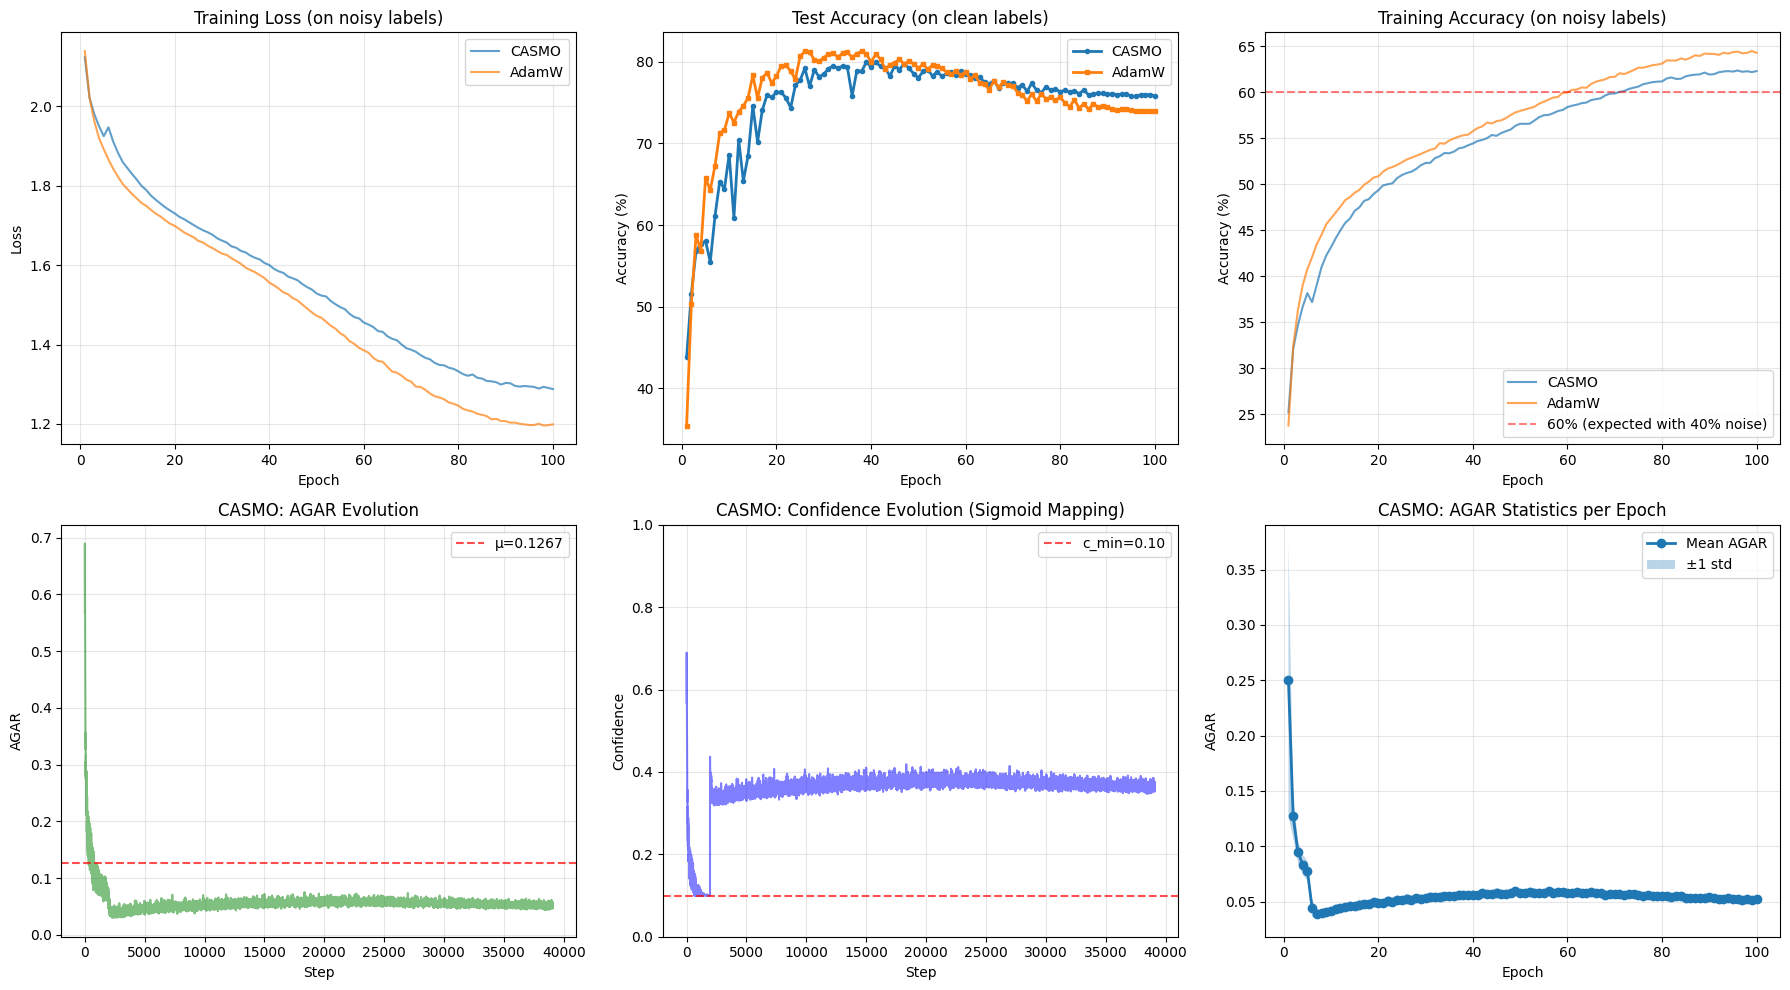


✅ Benchmark complete!


In [5]:
"""
ResNet-32 Noisy CIFAR-10 Benchmark with Checkpoint Support

Tests CASMO's ability to handle 40% label noise by detecting gradient quality.
Uses the new universal sigmoid-based confidence mapping.
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ResNet-32 for CIFAR-10 (standard architecture for noisy label research)
class BasicBlock(nn.Module):
    """Basic residual block for ResNet-32."""
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class ResNet(nn.Module):
    """ResNet for CIFAR-10."""
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet32(num_classes=10):
    """ResNet-32 for CIFAR-10 (5+5+5 blocks = 32 layers)."""
    return ResNet(BasicBlock, [5, 5, 5], num_classes=num_classes)


def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class NoisyCIFAR10(Dataset):
    """CIFAR-10 with symmetric label noise."""

    def __init__(self, base_dataset, noise_rate=0.4, seed=42):
        self.base_dataset = base_dataset
        self.noise_rate = noise_rate

        # Create noisy labels
        np.random.seed(seed)
        self.noisy_labels = []
        self.is_clean = []

        for idx in range(len(base_dataset)):
            _, true_label = base_dataset[idx]
            if np.random.random() < noise_rate:
                # Corrupt label: random class (excluding true class)
                noisy_label = np.random.choice([i for i in range(10) if i != true_label])
                self.noisy_labels.append(noisy_label)
                self.is_clean.append(False)
            else:
                # Keep clean label
                self.noisy_labels.append(true_label)
                self.is_clean.append(True)

        clean_count = sum(self.is_clean)
        print(f"Dataset: {len(self)} samples, {clean_count} clean ({100*clean_count/len(self):.1f}%), "
              f"{len(self)-clean_count} noisy ({100*(len(self)-clean_count)/len(self):.1f}%)")

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, _ = self.base_dataset[idx]
        noisy_label = self.noisy_labels[idx]
        return image, noisy_label


def get_agar_confidence(optimizer):
    """Extract current AGAR and confidence from CASMO optimizer."""
    if not hasattr(optimizer, '_group_states'):
        return None, None
    group_state = optimizer._group_states.get(0, {})
    return group_state.get('current_agar'), group_state.get('current_confidence')


def get_distribution_stats(optimizer):
    """Extract distribution statistics from CASMO optimizer."""
    if not hasattr(optimizer, '_group_states'):
        return None, None, None
    group_state = optimizer._group_states.get(0, {})
    return (group_state.get('agar_mean'),
            group_state.get('agar_std'),
            group_state.get('c_min'))


def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler, results, best_acc):
    """Save training checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'results': results,
        'best_acc': best_acc,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"  💾 Checkpoint saved: {checkpoint_path}")


def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    """Load training checkpoint."""
    if not os.path.exists(checkpoint_path):
        return None, None, None

    print(f"\n📂 Loading checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    start_epoch = checkpoint['epoch'] + 1
    results = checkpoint['results']
    best_acc = checkpoint['best_acc']

    print(f"✅ Resumed from epoch {checkpoint['epoch']}, best_acc={best_acc:.2f}%\n")
    return start_epoch, results, best_acc


def run_benchmark(optimizer_name, device, train_loader, test_loader, num_epochs=100,
                 lr=1e-3, weight_decay=5e-4, seed=42, checkpoint_dir='./checkpoints',
                 checkpoint_freq=10, resume=True):
    """Run training benchmark for one optimizer."""

    print(f"\n{'='*70}")
    print(f"Running: {optimizer_name.upper()}")
    print(f"{'='*70}\n")

    set_seed(seed)

    # Create checkpoint directory
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'{optimizer_name}_checkpoint.pth')

    # Load ResNet-32 (standard for CIFAR-10 noisy label research)
    model = resnet32(num_classes=10)
    print(f"Using ResNet-32 (standard for noisy label research)")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Create optimizer
    if optimizer_name == 'casmo':
        total_steps = len(train_loader) * num_epochs
        tau_init_steps = max(100, int(0.05 * total_steps))  # 5% calibration, min 100
        optimizer = CASMO(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            granularity='group',
            log_level=2,
            tau_init_steps=tau_init_steps,
            tau_dead_zone=1.0  # Frozen after calibration
        )
        print(f"CASMO tau_init_steps: {tau_init_steps}")
        print(f"Using universal sigmoid-based confidence mapping")
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Cosine annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Initialize results
    results = {
        'optimizer': optimizer_name,
        'train_losses': [],
        'train_accs': [],
        'test_losses': [],
        'test_accs': [],
        'agar_values': [],
        'confidence_values': [],
        'agar_per_epoch': [],
        'calibration_samples': [],
        'calibration_mu': None,
        'calibration_sigma': None,
        'calibration_c_min': None,
    }

    start_epoch = 0
    best_acc = 0
    start_time = time.time()

    # Try to resume from checkpoint
    if resume and os.path.exists(checkpoint_path):
        loaded = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        if loaded[0] is not None:
            start_epoch, results, best_acc = loaded
            if start_epoch >= num_epochs:
                print(f"⚠️  Training already complete (epoch {start_epoch}/{num_epochs})")
                return results

    try:
        for epoch in range(start_epoch, num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")

            # Training
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            epoch_agars = []

            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Track AGAR/confidence
                agar, conf = get_agar_confidence(optimizer)
                if agar is not None:
                    results['agar_values'].append(agar)
                    results['confidence_values'].append(conf)
                    epoch_agars.append(agar)

                # Capture calibration data (once)
                if optimizer_name == 'casmo' and results['calibration_mu'] is None:
                    group_state = optimizer._group_states.get(0, {})
                    if group_state.get('tau_initialized', False):
                        results['calibration_mu'] = group_state.get('agar_mean')
                        results['calibration_sigma'] = group_state.get('agar_std')
                        results['calibration_c_min'] = group_state.get('c_min')
                    elif len(group_state.get('agar_buffer', [])) > 0:
                        results['calibration_samples'] = list(group_state['agar_buffer'])

                if (batch_idx + 1) % 100 == 0:
                    msg = f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%"
                    if agar is not None:
                        msg += f", AGAR: {agar:.4f}, Conf: {conf:.4f}"
                    print(msg)

            if epoch_agars:
                results['agar_per_epoch'].append({
                    'epoch': epoch + 1,
                    'mean': np.mean(epoch_agars),
                    'std': np.std(epoch_agars),
                    'min': np.min(epoch_agars),
                    'max': np.max(epoch_agars)
                })

            train_loss /= len(train_loader)
            train_acc = 100. * correct / total
            results['train_losses'].append(train_loss)
            results['train_accs'].append(train_acc)

            # Testing (on clean test set)
            model.eval()
            test_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    test_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

            test_loss /= len(test_loader)
            test_acc = 100. * correct / total
            results['test_losses'].append(test_loss)
            results['test_accs'].append(test_acc)

            if test_acc > best_acc:
                best_acc = test_acc

            scheduler.step()

            print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
            print(f"  Test:  Loss={test_loss:.4f}, Acc={test_acc:.2f}%, Best={best_acc:.2f}%")

            # Print AGAR and distribution stats for CASMO
            if epoch_agars and (epoch + 1) % 10 == 0:
                mu, sigma, c_min = get_distribution_stats(optimizer)
                print(f"  AGAR: mean={np.mean(epoch_agars):.4f}, std={np.std(epoch_agars):.4f}, "
                      f"range=[{np.min(epoch_agars):.4f}, {np.max(epoch_agars):.4f}]")
                if mu is not None:
                    print(f"  Distribution: μ={mu:.4f}, σ={sigma:.4f}, c_min={c_min:.2f}")

            # Save checkpoint periodically
            if (epoch + 1) % checkpoint_freq == 0 or (epoch + 1) == num_epochs:
                save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler, results, best_acc)

            print()

    except KeyboardInterrupt:
        print("\n⚠️  Training interrupted! Saving checkpoint...")
        save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler, results, best_acc)
        print("✅ Checkpoint saved. You can resume training later.")
        raise

    except Exception as e:
        print(f"\n❌ Error during training: {e}")
        print("Saving checkpoint before exit...")
        save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler, results, best_acc)
        raise

    results['best_acc'] = best_acc
    results['total_time'] = time.time() - start_time

    print(f"Complete: {results['total_time']:.1f}s ({results['total_time']/60:.1f} min)")
    print(f"Best Test Accuracy: {best_acc:.2f}%\n")

    # Print final calibration info for CASMO
    if optimizer_name == 'casmo' and results['calibration_mu'] is not None:
        print(f"Final CASMO calibration:")
        print(f"  μ (mean AGAR): {results['calibration_mu']:.4f}")
        print(f"  σ (std AGAR): {results['calibration_sigma']:.4f}")
        print(f"  c_min (adaptive): {results['calibration_c_min']:.2f}")
        cv = results['calibration_sigma'] / (results['calibration_mu'] + 1e-8)
        print(f"  CV (coefficient of variation): {cv:.4f}")
        if cv < 0.3:
            print(f"  → Low variance detected: Using high c_min for pervasive noise")
        elif cv < 0.5:
            print(f"  → Medium variance: Moderate discrimination")
        else:
            print(f"  → High variance: Strong discrimination for bimodal distribution")
        print()

    # Clean up checkpoint after successful completion
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        print(f"🗑️  Removed checkpoint (training complete)\n")

    return results


def main():
    """Main benchmark execution."""
    print("="*70)
    print("CASMO vs AdamW Benchmark - Noisy CIFAR-10 (40% Label Corruption)")
    print("Architecture: ResNet-32 (standard for noisy label research)")
    print("="*70)

    set_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nDevice: {device}")

    # Data loading
    print("\nLoading CIFAR-10 dataset...")
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load base datasets
    base_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    # Create noisy training set (40% label corruption)
    print("\nCreating noisy training set (40% label corruption)...")
    noisy_train = NoisyCIFAR10(base_train, noise_rate=0.4, seed=42)

    train_loader = DataLoader(noisy_train, batch_size=128, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

    print(f"\nTrain: {len(noisy_train)} (noisy), Test: {len(test_dataset)} (clean)")
    print(f"Batches per epoch: {len(train_loader)}")
    print(f"\n⚠️  Training on NOISY labels, testing on CLEAN labels")
    print(f"This tests the optimizer's ability to learn despite label noise.")
    print(f"\n💾 Checkpoints will be saved every 10 epochs\n")

    # Run benchmarks (100 epochs)
    casmo_results = run_benchmark('casmo', device, train_loader, test_loader,
                                  num_epochs=100, seed=42, checkpoint_freq=10, resume=True)
    adamw_results = run_benchmark('adamw', device, train_loader, test_loader,
                                  num_epochs=100, seed=42, checkpoint_freq=10, resume=True)

    # Comparison
    print("\n" + "="*70)
    print("FINAL COMPARISON")
    print("="*70)

    casmo_acc = casmo_results['best_acc']
    adamw_acc = adamw_results['best_acc']
    acc_diff = (casmo_acc - adamw_acc) / adamw_acc * 100

    print(f"\nBest Test Accuracy (on clean labels):")
    print(f"  CASMO:  {casmo_acc:.2f}%")
    print(f"  AdamW:  {adamw_acc:.2f}%")
    print(f"  Diff:   {acc_diff:+.2f}% {'(CASMO wins!)' if acc_diff > 0 else '(AdamW wins)'}")

    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    epochs = list(range(1, len(casmo_results['test_accs']) + 1))

    # Training loss
    axes[0, 0].plot(epochs, casmo_results['train_losses'], label='CASMO', alpha=0.7)
    axes[0, 0].plot(epochs, adamw_results['train_losses'], label='AdamW', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss (on noisy labels)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Test accuracy
    axes[0, 1].plot(epochs, casmo_results['test_accs'], 'o-', label='CASMO', linewidth=2, markersize=3)
    axes[0, 1].plot(epochs, adamw_results['test_accs'], 's-', label='AdamW', linewidth=2, markersize=3)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Test Accuracy (on clean labels)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training accuracy
    axes[0, 2].plot(epochs, casmo_results['train_accs'], label='CASMO', alpha=0.7)
    axes[0, 2].plot(epochs, adamw_results['train_accs'], label='AdamW', alpha=0.7)
    axes[0, 2].axhline(y=60, color='r', linestyle='--', alpha=0.5, label='60% (expected with 40% noise)')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy (%)')
    axes[0, 2].set_title('Training Accuracy (on noisy labels)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # AGAR evolution
    if casmo_results['agar_values']:
        axes[1, 0].plot(casmo_results['agar_values'], color='green', alpha=0.5)
        axes[1, 0].set_xlabel('Step')
        axes[1, 0].set_ylabel('AGAR')
        axes[1, 0].set_title('CASMO: AGAR Evolution')
        axes[1, 0].grid(True, alpha=0.3)

        # Add calibration line if available
        if casmo_results['calibration_mu'] is not None:
            axes[1, 0].axhline(y=casmo_results['calibration_mu'], color='red',
                              linestyle='--', alpha=0.7, label=f"μ={casmo_results['calibration_mu']:.4f}")
            axes[1, 0].legend()

    # Confidence evolution
    if casmo_results['confidence_values']:
        axes[1, 1].plot(casmo_results['confidence_values'], color='blue', alpha=0.5)
        axes[1, 1].set_xlabel('Step')
        axes[1, 1].set_ylabel('Confidence')
        axes[1, 1].set_title('CASMO: Confidence Evolution (Sigmoid Mapping)')
        axes[1, 1].set_ylim([0, 1.0])
        axes[1, 1].grid(True, alpha=0.3)

        # Add c_min line if available
        if casmo_results['calibration_c_min'] is not None:
            axes[1, 1].axhline(y=casmo_results['calibration_c_min'], color='red',
                              linestyle='--', alpha=0.7, label=f"c_min={casmo_results['calibration_c_min']:.2f}")
            axes[1, 1].legend()

    # AGAR statistics per epoch
    if casmo_results['agar_per_epoch']:
        agar_epochs = [x['epoch'] for x in casmo_results['agar_per_epoch']]
        agar_means = [x['mean'] for x in casmo_results['agar_per_epoch']]
        agar_stds = [x['std'] for x in casmo_results['agar_per_epoch']]
        axes[1, 2].plot(agar_epochs, agar_means, 'o-', label='Mean AGAR', linewidth=2)
        axes[1, 2].fill_between(
            agar_epochs,
            [m - s for m, s in zip(agar_means, agar_stds)],
            [m + s for m, s in zip(agar_means, agar_stds)],
            alpha=0.3, label='±1 std'
        )
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('AGAR')
        axes[1, 2].set_title('CASMO: AGAR Statistics per Epoch')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('noisy_cifar10_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✅ Plot saved: noisy_cifar10_comparison.png")
    plt.show()

    print("\n✅ Benchmark complete!")


if __name__ == '__main__':
    main()
